# Tache 9 : Jérémy Roger

In [87]:
import numpy as np
from mp_api.client import MPRester
from scipy.optimize import minimize
from scipy import integrate
from scipy.integrate import quad
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [88]:
# HfNiSn
mp_key = "fnNhNeZr2KXTJ64m73UhQ93prbDkSyqH"
mp_id = "mp-924128"

In [89]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [91]:
Temp = np.arange(5, 1000, 5)
R = 8.314
Nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(Temp[i]) for i in range(len(Temp))]) / (3 * Nat * R)

On a que la valeur théorique pour le modèle d'Einstein découle de cette formule : 
$$\frac{C_v}{3N_aR} = \left(\frac{\Theta_E}{T}\right)^2 \cdot \frac{e^{\frac{\Theta_E}{T}}}{\left(e^{\frac{\Theta_E}{T}} - 1\right)^2}$$

Ou $\Theta_E$ est la température d'Einstein recherchée.

Pour le modèle de Debye on a cette formule ci : 
$$\frac{C_v}{3N_aR} = 9 \left(\frac{T}{\Theta_D}\right)^3 \int_0^{\frac{\Theta_D}{T}} \frac{x^4 e^x}{(e^x - 1)^2} dx$$

Ou $\Theta_D$ est la température de Debye recherchée.


## Einstein

La valeur de Θ_E qui minimise l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique est :  311.68722343701074 K


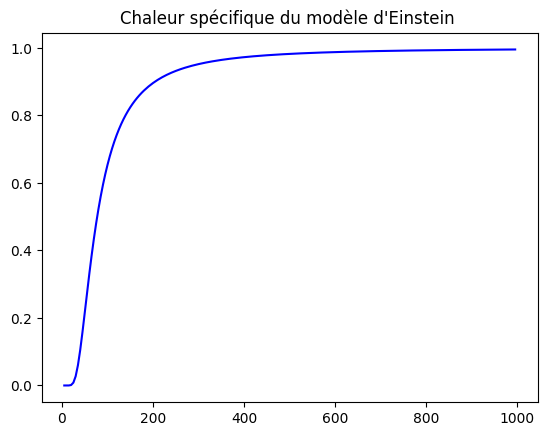

In [92]:
def theoretical_Cv_Einstein(Te, T):
    return ((Te/T)**2 * np.exp(Te/T)) / ((np.exp(Te/T) - 1)**2)

def error_func(Te, temps, cv_exp):
    cv_theo = theoretical_Cv_Einstein(Te, temps)
    return np.sum((cv_theo - cv_exp)**2)

temperatures = np.array(Temp)
Cv_exp = np.array(ph_cv)

T_initial = 10
result = minimize(error_func, T_initial, args=(Temp, Cv_exp))
Te_optimal = result.x[0]

print("La valeur de Θ_E qui minimise l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique est : ", T_optimal,"K")

Cv_einstein = theoretical_Cv_Einstein(Te_optimal, temperatures)

plt.plot(Temp, Cv_einstein, label='Einstein', linestyle='-', color='blue')
plt.title("Chaleur spécifique du modèle d'Einstein ")
plt.show()

## Debye

La valeur optimale de Td qui minimise l'erreur au carré est : 311.68722343701074 K


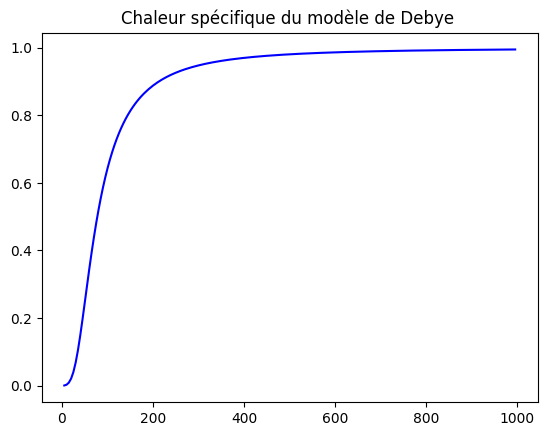

In [93]:
def theoretical_Cv_Debye(Td, T):
    def integrand(x):
        return (x**4 * np.exp(x)) / ((np.exp(x)-1)**2)
    
    result = 3 * ((T / Td)**3) * quad(integrand, 0, Td / T)[0]
    return result

def squared_error_Debye(Td, temps_exp, cv_exp):
    squared_errors = [(theoretical_Cv_Debye(Td, temps_exp[i]) - cv_exp[i])**2 for i in range(len(temps_exp))]
    return sum(squared_errors)

T_initial = 10 
result = minimize(squared_error_Debye, T_initial, args=(Temp, ph_cv))
Td_optimal = result.x[0]

print("La valeur optimale de Td qui minimise l'erreur au carré est :", T_optimal,"K")

Cv_debye = np.array([theoretical_Cv_Debye(Td_optimal, temp) for temp in temperatures])

plt.plot(Temp, Cv_debye, label='Debye', linestyle='-', color='blue')
plt.title('Chaleur spécifique du modèle de Debye ')
plt.show()

## Plot des chaleurs spécifiques

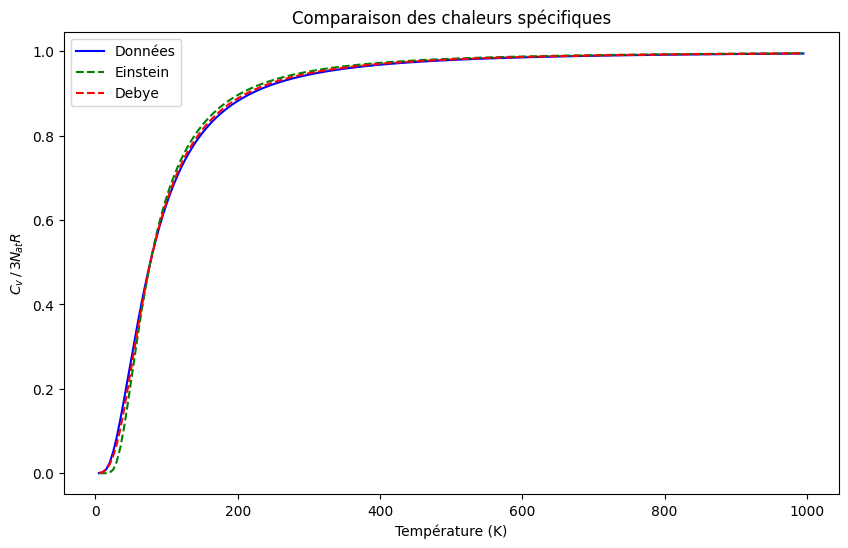

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(Temp, ph_cv, label='Données', color='blue')
plt.plot(Temp, Cv_einstein, label='Einstein', linestyle='--', color='green')
plt.plot(Temp, Cv_debye, label='Debye', linestyle='--', color='red')

plt.xlabel('Température (K)')
plt.ylabel('$C_v\,/\,3N_{\!at}R$')
plt.title('Comparaison des chaleurs spécifiques')
plt.legend()
plt.show()

## Densités d'états de phonons

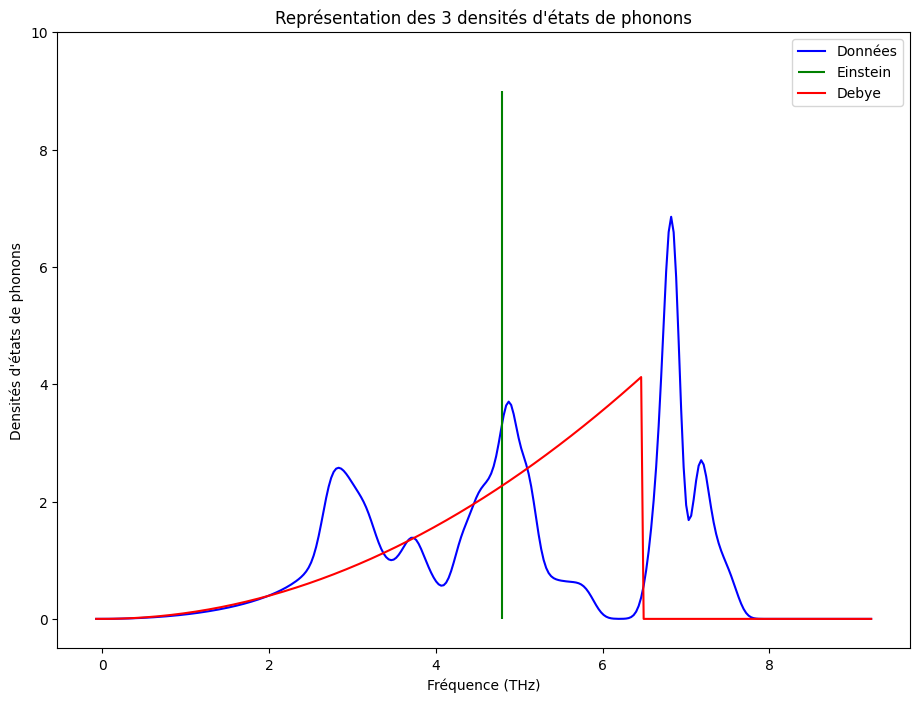

In [95]:
k_B = 1.380649e-23   
h_b = 1.055e-34   
THz = 1e-12

Freq = ph_dos.frequencies 
Dens = ph_dos.densities

T_e = THz * k_B * Te_optimal /h_b
F_e = T_e/(2*np.pi)   

T_d = THz * k_B * Td_optimal /h_b

dens_d = np.zeros(len(Freq))
for i,f in enumerate(Freq):
    T = 2*np.pi*f
    if T < T_d:
        dens_d[i] = (9*Nat*(T)**2/(T_d**3))

plt.figure(figsize=(11, 8))
plt.plot(Freq, Dens,color = "blue", label="Données")
plt.vlines(F_e, 0, 3 * Nat ,color ="green", label = "Einstein") 
plt.plot(Freq, dens_d*(2*np.pi), color='red', label="Debye")
plt.title("Représentation des 3 densités d'états de phonons")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence (THz)")
plt.ylim(-0.5, 10)
plt.legend()
plt.show()
